# Regression diagnostics in Python

 When we fit a linear regression model to a particular data set, many problems may occur. Most common among these are the following {cite:p}`James2021`:

1. High-leverage points
2. Non-linearity of the response-predictor relationship
3. Non-constant variance of error terms (heteroskedasticity)
4. Non-normally distributed errors
5. Correlation of error terms
6. Multicollinearity

As an example of how to identify and overcome these problems, we use data about the prestige of canadian occupations to estimate a regression model with `prestige` as the response and `income` and `education` as predictors. Review this [site](https://vincentarelbundock.github.io/Rdatasets/doc/carData/Prestige.html) to learn more about the data.

*This tutorial is mainly based on the [statmodels documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html#Partial-Regression-Plots-(Crime-Data)) about regression plots.*

 ## Python setup

In [2]:
import numpy as np
import pandas as pd
from patsy import dmatrices

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

## Import data

We use the function `.datasets.get_rdataset` to load a dataset from the <a href="https://vincentarelbundock.github.io/Rdatasets/">Rdatasets package</a>. 

In [3]:
df = sm.datasets.get_rdataset("Duncan", "carData", cache=True).data

In [4]:
df.head()

,type,income,education,prestige
accountant,prof,62,86,82
pilot,prof,72,76,83
architect,prof,75,92,90
author,prof,55,90,76
chemist,prof,64,86,90


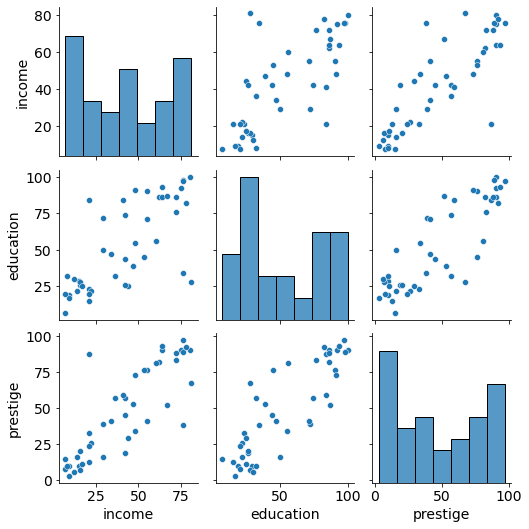

In [5]:
sns.pairplot(df);

## Model

In [6]:
# Estimate the model and save it as lm (linear model)
lm = ols("prestige ~ income + education", data=df).fit()

In [7]:
# print regression results
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     101.2
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           8.65e-17
Time:                        17:25:35   Log-Likelihood:                -178.98
No. Observations:                  45   AIC:                             364.0
Df Residuals:                      42   BIC:                             369.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0647      4.272     -1.420      0.1

# Diagnostics

## High-leverage points

 In a regression analysis, single observations can have a strong influence on the results of the model. For example, in the plot below we can see how a single outlying data point can affect a model.

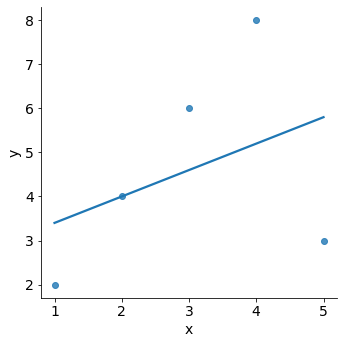

In [8]:
df_outlier = pd.DataFrame(
        { 'observation': pd.Categorical([ "A", "B", "C", "D", "E" ]),
          'x': np.array([1, 2, 3, 4, 5],dtype='int32'),
          'y': np.array([2, 4, 6, 8, 3],dtype='int32')}
        )

sns.lmplot(x="x", y="y", data=df_outlier, ci=False);

We just saw that outliers are observations for which the response $y_i$ is unusual given the predictor $x_i$. In contrast, observations with high **leverage** have an unusual value for $x_i$.

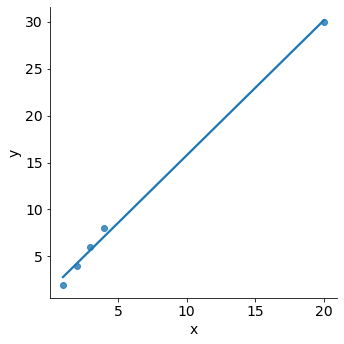

In [9]:
df_leverage = pd.DataFrame(
        { 'observation': pd.Categorical([ "A", "B", "C", "D", "E" ]),
          'x': np.array([1, 2, 3, 4, 20],dtype='int32'),
          'y': np.array([2, 4, 6, 8, 30],dtype='int32')}
        )

sns.lmplot(x="x", y="y", data=df_leverage, ci=False);

For example, observation E has high leverage, in that the predictor value for this observation is large relative to the other observations. The removal of the high leverage observation would have a substantial impact on the regression line. In general, high leverage observations tend to have a sizable impact on the estimated regression line.

Therefore, it is important to detect influential observations and to take them into consideration when interpreting the results.

### Influence plots

We can use **influence plots** to identify observations in our independent variables which have "unusual" values in comparison to other values. 

Influence plots show the (externally) studentized residuals vs. the leverage of each observation:

Dividing a statistic by a sample standard deviation is called **studentizing**, in analogy with standardizing and normalizing. The basic idea is to: 

1. Delete the observations one at a time.
2. Refit the regression model each time on the remaining n–1 observations. 
3. Compare the observed response values to their fitted values based on the models with the ith observation deleted. This produces unstandardized deleted residuals. 
4. Standardising the deleted residuals produces studentized deleted residuals (also known as externally studentized residuals)

In summary, externally studentized residuals are residuals that are scaled by their standard deviation. If an observation has an externally studentized residual that is larger than 3 (in absolute value) we can call it an outlier. Values greater then 2 (in absolute values) are usually also of interest.

**Leverage** is a measure of how far away the independent variable values of an observation are from those of the other observations. High-leverage points are outliers with respect to the independent variables. 


> In summmary: Influence plots are used to identify influential data points. They depend on both the residual and leverage i.e they take itnto account both the $x$ value and $y$ value of the observation.

In statsmodel's `.influence_plot` the influence of each point can be visualized by the `criterion` keyword argument. Options are Cook's distance and DFFITS, two measures of influence. Steps to compute Cook’s distance:

1. Delete observations one at a time.
2. Refit the regression model on remaining (n−1) observations
3. Examine how much all of the fitted values change when the ith observation is deleted.

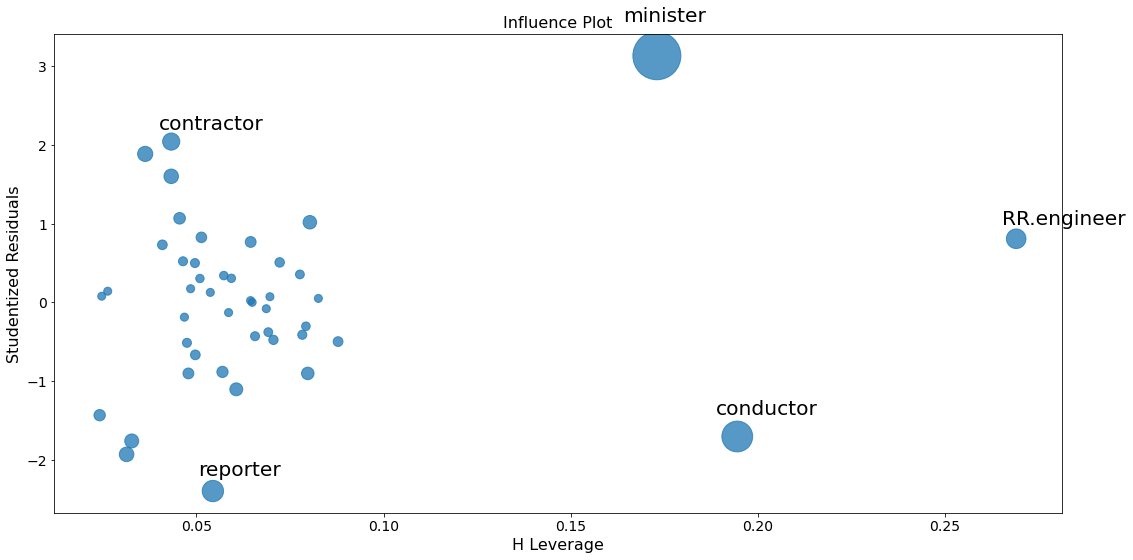

In [10]:
fig = sm.graphics.influence_plot(lm, criterion="cooks")
fig.tight_layout(pad=1.0)

To identify values with high influence, we look for observations with:

1. big blue points (high Cook's distance) and 
1. high leverage (X-axis) which additionally have 
2. high or low studentized residuals (Y-axis). 

There are a few worrisome observations with big blue dots in the plot:

- `RR.engineer` has large leverage but small residual. 
- Both `contractor` and `reporter` have low leverage but a large residual. 
- `Conductor` and `minister` have both high leverage and large residuals, and, therefore, large influence.

A general rule of thumb is that observations with a **Cook’s distance** over $4/n$ (where n is the number of observations) are possible outliers with leverage.  

In addition to our plot, we can use the function `.get_influence()` to assess the influence of each observation and compare them to the cricital Cook's distance :

In [11]:
# obtain Cook's distance 
lm_cooksd = lm.get_influence().cooks_distance[0]

# get length of df to obtain n
n = len(df["income"])

# calculate critical d
critical_d = 4/n
print('Critical Cooks distance:', critical_d)

# identification of potential outliers with leverage
out_d = lm_cooksd > critical_d

# output potential outliers with leverage
print(df.index[out_d], "\n", 
    lm_cooksd[out_d])

Critical Cooks distance: 0.08888888888888889
Index(['minister', 'reporter', 'conductor'], dtype='object') 
 [0.56637974 0.09898456 0.22364122]


We will deal with the crictical values in the section below. 

## Non-linearity and heteroscedasticity

One crucial assumption of the linear regression model is the linear relationship between the response and the dependent variables. We can identify non-linear relationships in the regression model residuals if the residuals are not equally spread around the horizontal line (where the residuals are zero) but instead show a pattern, then this gives us an indication for a non-linear relationship. 

We can deal with non-linear relationships via basis expansions (e.g. polynomial regression) or regression splines (see {cite:t}`Kuhn2019`](http://www.feat.engineering/numeric-one-to-many.html#numeric-basis-functions))

Another important assumption is that the error terms have a constant variance (homoscedasticity). For instance, the variances of the error terms may increase with the value of the response. One can identify non-constant variances in the errors, or heteroscedasticity, from the presence of a funnel shape in a residual plot. 

When faced with this problem, one possible solution is to use [weighted regression](https://www.statsmodels.org/dev/examples/notebooks/generated/wls.html). This type of regression assigns a weight to each data point based on the variance of its fitted value. Essentially, this gives small weights to data points that have higher variances, which shrinks their squared residuals. When the proper weights are used, this can eliminate the problem of heteroscedasticity.

### Partial Regression Plots

Since we are doing multivariate regressions, we cannot just look at individual bivariate plots (e.g., prestige and income) to identify the type of relationships between response and predictor. Instead, we want to look at the relationship of the dependent variable and independent variables *conditional* on the other independent variables. We can do this through using **partial regression plots**, otherwise known as **added variable plots**. 

With partial regression plots you can:

1. Investigate the relationship between a dependent and independent variables.
2. Identify the effects of the individual data values on the estimation of a coefficient. 
3. Investigate violations of underlying assumptions such as linearity and homoscedasticity.

If we want to identify the relationship between `prestige` and `income`, we would proceed as follows (we name the independent variable of interest $X_k$ and all other independent variables $X_{\sim k}$):

<br/>

1. Compute a regression model by regressing the response variable versus the independent variables excluding $X_k$:
    - response variable: `prestige`
    - $X_k$: `income`
    - $X_{\sim k}$: `education`
    - Model($X_{\sim k}$): `(prestige ~ education)`  

<br/>

2. Compute the residuals of Model($X_{\sim k}$): 
    - $R_{X_{\sim k}}$: residuals of Model($X_{\sim k}$): 

<br/>

3. Compute a new regression model by regressing $R_{X_{\sim k}}$ on $X_{\sim k}$. 
    - Model($X_k$): $R_{X_{\sim k}}$ ~ `income`

<br/>

4. Compute the residuals of Model($X_k$): 
    - $R_{X_{k}}$: residuals of Model($X_{k}$): 

<br/>

5. Make a partial regression plot by plotting the residuals from $R_{X_{\sim k}}$ against the residuals from $R_{X_{k}}$:
    - Plot with X = $R_{X_{k}}$ and Y = $R_{X_{\sim k}}$

<br/>

For a quick check of all the regressors, you can use `plot_partregress_grid`. These plots will not label the 
points, but you can use them to identify problems and then use `plot_partregress` to get more information.

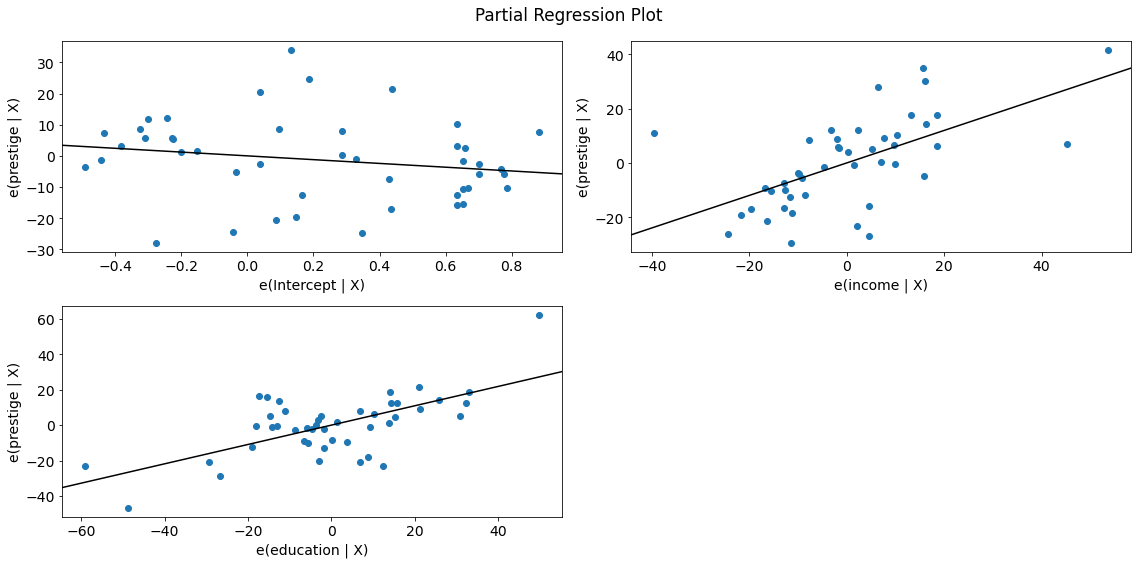

In [12]:
fig = sm.graphics.plot_partregress_grid(lm)
fig.tight_layout(pad=1.0)

We observe a positive relationship between prestige and income as well as between prestige and education. The relationship seems to be linear in both cases.

Next, let's take a closer look at the observations.

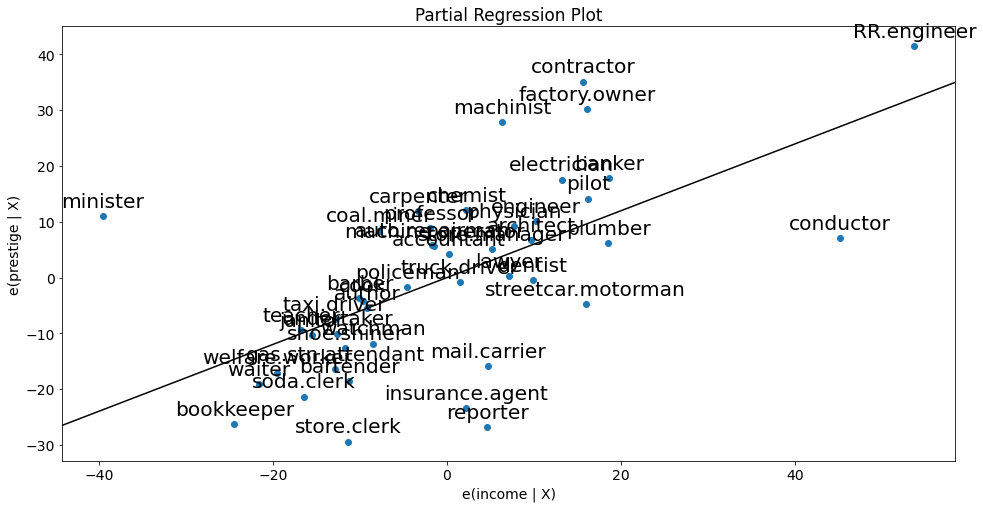

In [13]:
sm.graphics.plot_partregress(
                             endog='prestige', # response
                             exog_i='income', # variable of interest
                             exog_others=['education'], # other predictors
                             data=df,  # dataframe
                             obs_labels=True # show labels
                             );

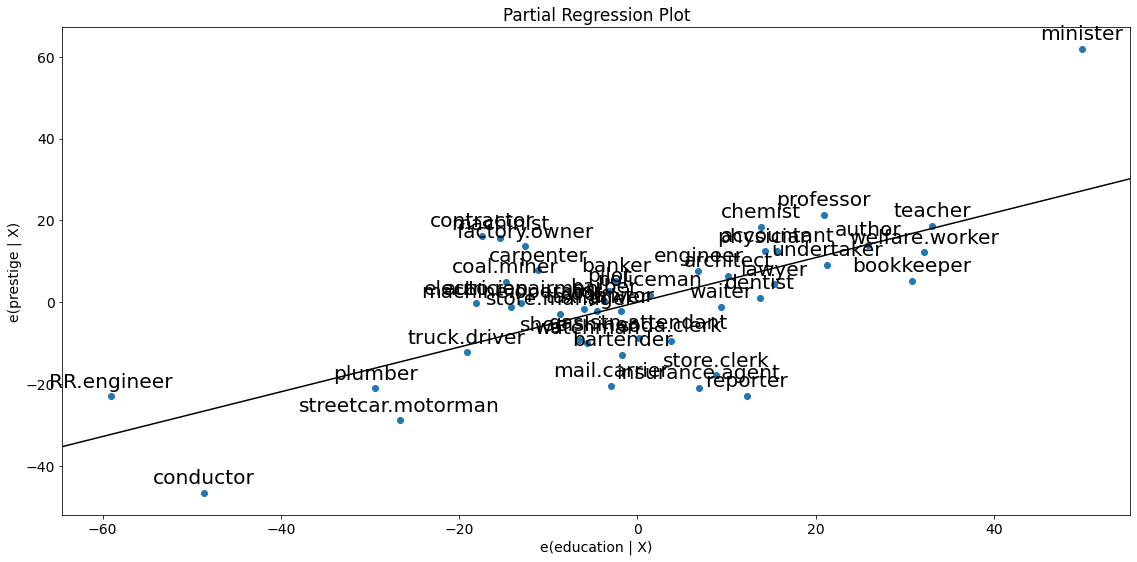

In [14]:
# same plot for education
fig = sm.graphics.plot_partregress("prestige", "education", ["income"], data=df)
fig.tight_layout(pad=1.0)

The partial regression plots confirm the influence of `conductor`, `minister` on the partial relationships between prestige and the predictors income and education. The influence of `reporter` is less obvious but since the observation was considered critical according to Cook`s D, we also drop this case.

Note that influential cases potentially bias the effect of income and education on prestige. Therefore, we will drop these cases and perform a linear regression without them.

In [15]:
# make a subset and flag as TRUE if index doesn't contain ...
subset = ~df.index.isin(["conductor", "minister", "reporter"])

print(df.index, "\n", subset)

Index(['accountant', 'pilot', 'architect', 'author', 'chemist', 'minister',
       'professor', 'dentist', 'reporter', 'engineer', 'undertaker', 'lawyer',
       'physician', 'welfare.worker', 'teacher', 'conductor', 'contractor',
       'factory.owner', 'store.manager', 'banker', 'bookkeeper',
       'mail.carrier', 'insurance.agent', 'store.clerk', 'carpenter',
       'electrician', 'RR.engineer', 'machinist', 'auto.repairman', 'plumber',
       'gas.stn.attendant', 'coal.miner', 'streetcar.motorman', 'taxi.driver',
       'truck.driver', 'machine.operator', 'barber', 'bartender',
       'shoe.shiner', 'cook', 'soda.clerk', 'watchman', 'janitor', 'policeman',
       'waiter'],
      dtype='object') 
 [ True  True  True  True  True False  True  True False  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


In [16]:
# compute regression without influential cases
lm2 = ols("prestige ~ income + education", data=df, subset=subset).fit()

print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     169.0
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           6.13e-20
Time:                        17:25:37   Log-Likelihood:                -157.02
No. Observations:                  42   AIC:                             320.0
Df Residuals:                      39   BIC:                             325.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.2414      3.391     -2.136      0.0


Dropping the influential cases confirms our believe. The new regression model without the influential cases is superior to the initial one. To see this, compare the regression summary above with our initial summary (see $R^2$, adjusted $R^2$, F-statistic and the new coefficients).

### CCPR plots

The Component-Component plus Residual (CCPR) plot provides another way to judge the effect of one regressor on the response variable by taking into account the effects of the other independent variables. They are also a good way to see if the predictors have a linear relationship with the dependent variable.

A CCPR plot consists of a partial residuals plot and a component: 

1. The partial residuals plot is defined as $\text{Residuals} + \hat\beta_{i} X_i \text{ }\text{ }$ versus $X_i$, where
  
    - Residuals = residuals from the full model
    - $\hat\beta_{i}$ = regression coefficient from the ith independent variable in the full model
    - $X_i$ = the ith independent variable

2. The component adds $\hat\beta_{i}$ $X_i$ versus $X_i$ to show where the fitted line would lie. 
 
A significant difference between the residual line and the actual distribution of values indicates that the predictor does not have a linear relationship with the dependent variable. 

*Care should be taken if $X_i$ is highly correlated with any of the other independent variables (see multicollinearity). If this is the case, the variance evident in the plot will be an underestimate of the true variance.*

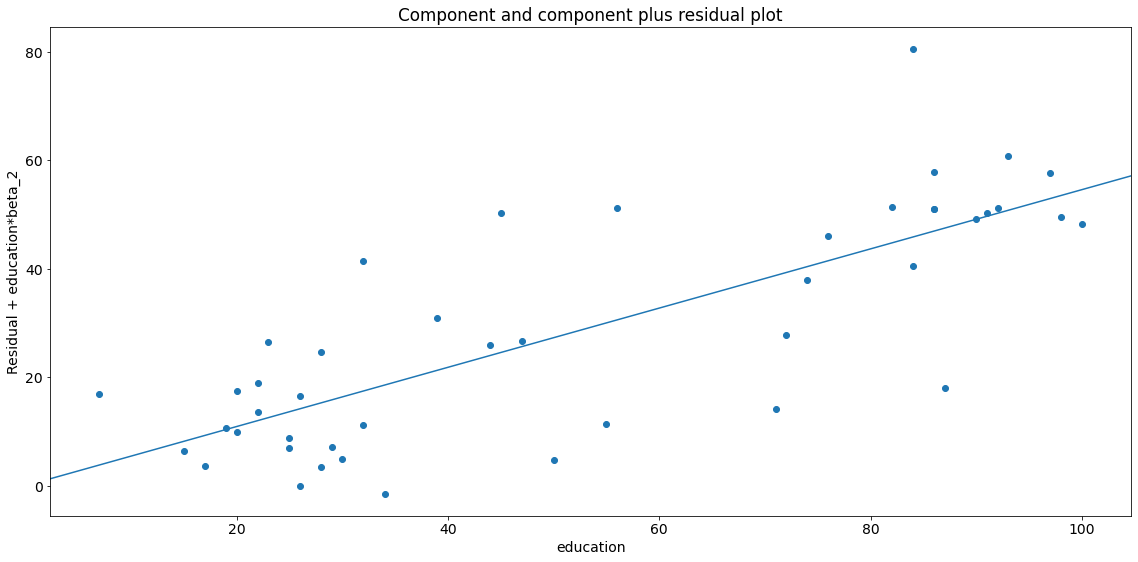

In [17]:
fig = sm.graphics.plot_ccpr(lm, "education")
fig.tight_layout(pad=1.0)

As you can see the relationship between the variation in $y$ explained by education conditional on income seems to be linear, though you can see there are some observations that are exerting considerable influence on the relationship. 

We can quickly look at more than one variable by using `plot_ccpr_grid`.

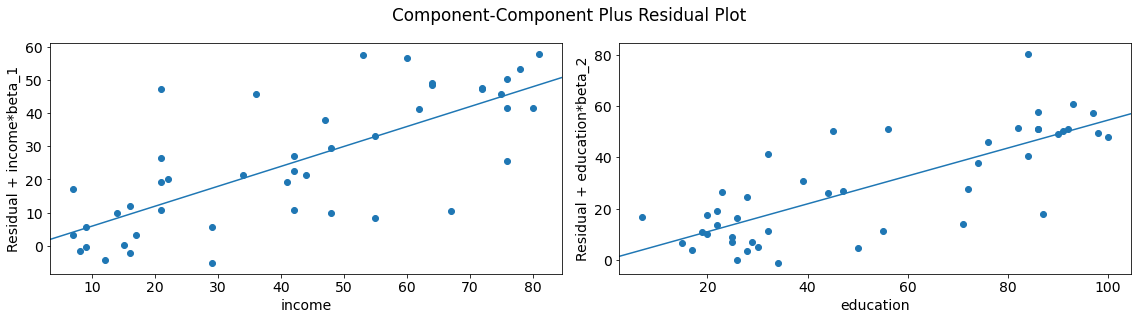

In [18]:
fig = sm.graphics.plot_ccpr_grid(lm)
fig.tight_layout(pad=1.0)

### Residuals vs fitted plot

Residual plots are a useful graphical tool for identifying non-linearity as well as heteroscedasticity. The residuals of this plot are those of the regression fit with all predictors. 

You can use [seaborn's residplot](https://seaborn.pydata.org/generated/seaborn.residplot.html) to investigate possible violations of underlying assumptions such as linearity and homoskedasticity.

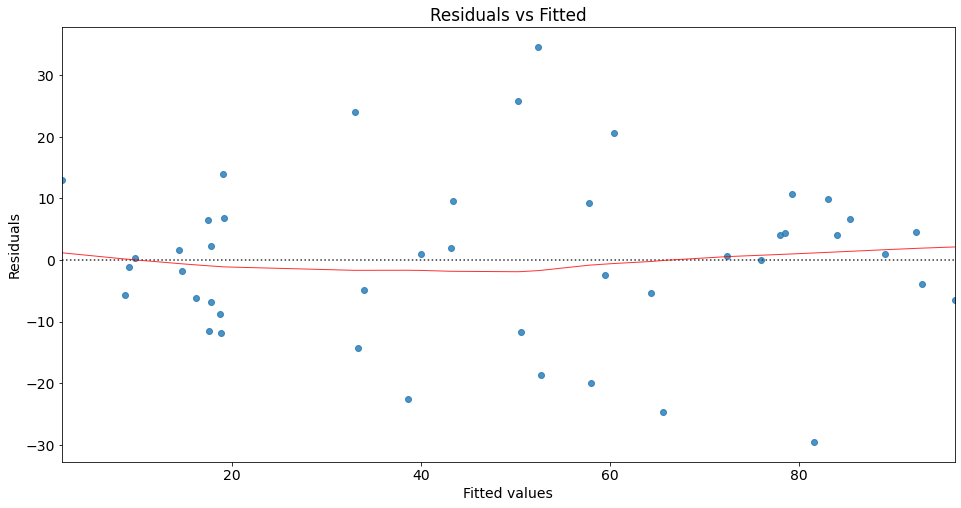

In [21]:
# fitted values
model_fitted_y = lm.fittedvalues

#  Plot
plot = sns.residplot(x=model_fitted_y, y='prestige', data=df, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# Titel and labels
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals');

This plot shows how residuals are spread along the ranges of predictors. This is how we can check the assumption of linearity and equal variance (homoscedasticity) in the full model. It’s a good sign if we observe relatively equal (randomly) spreaded points along the dashed horizontal line. 

The red line indicates the fit of a locally weighted scatterplot smoothing (lowess), a local regression method, smoother to the residual scatterplot.

Local regression is a different approach for fitting flexible non-linear functions, which involves computing the fit at a target point $x_0$ using only the nearby training observations {see cit:t}`James2021` for more details).

LOWESS (Locally Weighted Scatterplot Smoothing), sometimes called LOESS (locally weighted smoothing), is a popular tool used in regression analysis that creates a smooth line through a timeplot or scatter plot to help you to see relationship between variables and foresee trends.


We included a 

In our model the residuals seem to spread a bit wider along the y-axis as they pass the x value around 2. Because the residuals spread wider and wider with an increase of x, this could be an indication of heteroscedasticity. However, the pattern is not obvious and we see a decrease as they pass the x value around 3. 

We can use an additional test to test our presumtion.

#### Breusch-Pagan Lagrange Multiplier test

The Breusch-Pagan Lagrange Multiplier test can be used to identify heteroscedasticity. The test assumes homoscedasticity (this is the null hypothesis $H_0$) which means that the residual variance does not depend on the values of the variables in x.

Note that this test may exaggerate the significance of results in small or moderately large samples {cite:p}`Greene2000`. In this case the F-statistic is preferable.

If one of the test statistics is significant (i.e., p <= 0.05), then you have indication of heteroscedasticity. 

In [20]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(lm.resid, lm.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 0.5752191351127306),
 ('p-value', 0.7500543806429694),
 ('f-value', 0.27191134322318933),
 ('f p-value', 0.7632527707017838)]

In our case, both p-values are above 0.05, which means we can accept the null hypothesis. Therefore, we have an indication of homoscedasticity. 

### Single Variable Regression Diagnostics

The `plot_regress_exog` function is a convenience function which can be used for quickly checking modeling assumptions with respect to a single regressor.

It gives a 2x2 plot containing the: 

1. dependent variable and fitted values with confidence intervals vs. the independent variable chosen (includes prediction confidence intervals), 
2. the residuals of the model vs. the chosen independent variable, 
3. a partial regression plot, and a 
4. CCPR plot. 

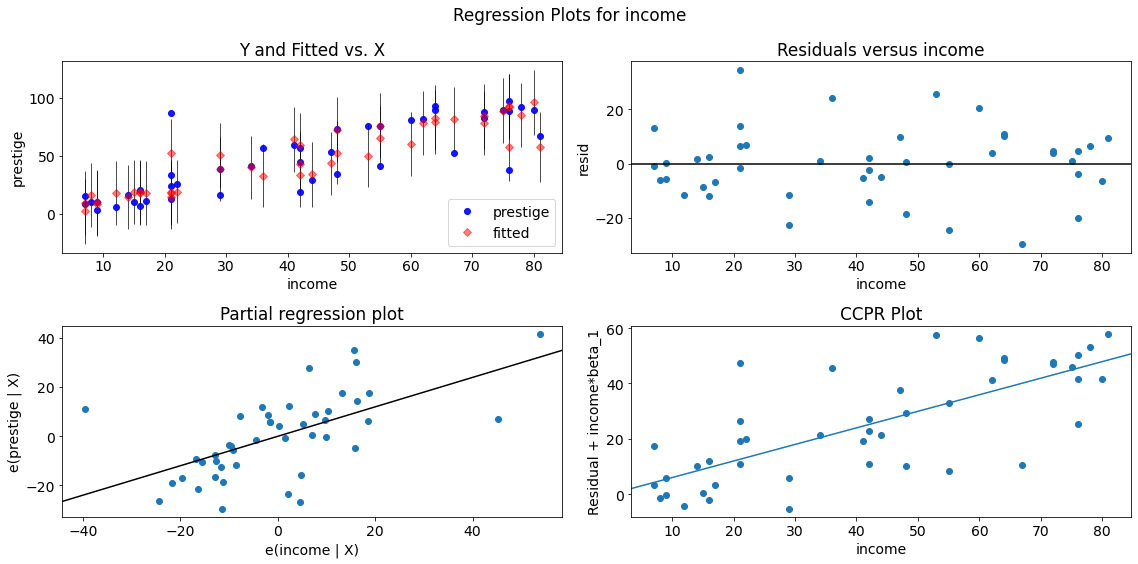

In [21]:
fig = sm.graphics.plot_regress_exog(lm, "income")
fig.tight_layout(pad=1.0)

## Non-normally distributed errors

It can be helpful if the residuals in the model are random, normally distributed variables with a mean of 0. This assumption means that the differences between the predicted and observed data are most frequently zero or very close to zero, and that differences much greater than zero happen only occasionally. 

Note that non-normally distributed errors are not problematic for our model parameters but they may effect significance tests and confidence intervals.


### Jarque-Bera test

The Jarque–Bera (JB) test is a goodness-of-fit test of whether sample data have the *skewness* and *kurtosis* matching a normal distribution. 

The null hypothesis ($H_0$) is a joint hypothesis of: 

1. the skewness being zero and 
2. the kurtosis being 3. 

Samples from a normal distribution have an:

1. expected skewness of 0 and 
2. an expected *excess* kurtosis of 0 (which is the same as a kurtosis of 3). 
 
Any deviation from this assumptions increases the JB statistic.

Next, we calculate the statistics but you can also find the results of the Jarque-Bera test in the regression summary. 

In [26]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(lm.resid)

lzip(name, test)

[('Jarque-Bera', 0.5195278349686433),
 ('Chi^2 two-tail prob.', 0.7712336390906139),
 ('Skew', 0.1549318677987544),
 ('Kurtosis', 3.425518480614924)]

The p-value is above 0.05 and we can accept $H_0$. Therefore, the test gives us an indication that the errors are normally distributed.

### Omnibus normtest

Another test for normal distribution of residuals is the Omnibus normtest (also included in the regression summary). The test allows us to check whether or not the model residuals follow an approximately normal distribution.

Our null hypothesis ($H_0$) is that the residuals are from a normal distribution.

In [31]:
name = ['Chi^2', 'Two-tail probability']
test = sm.stats.omni_normtest(lm.resid)
lzip(name, test)

[('Chi^2', 1.2788071145675917), ('Two-tail probability', 0.5276070175778638)]

The p-value is above 0.05 and we can accept $H_0$. Therefore, the test gives us an indication that the errors are from a normal distribution.

## Correlation of error terms

Another important assumption of the linear regression model is that the error terms are uncorrelated.

Such correlations frequently occur in the context of time series data, which consists of observations for which measurements are obtained at discrete points in time. In many cases, observations that are obtained at adjacent time points will have positively correlated errors. In order to determine if this is the case for a given data set, we can plot the residuals from our model as a function of time. If the errors are uncorrelated, then there should be no discernible pattern.

Correlation among the error terms can also occur outside of time series data. For instance, consider a study in which individuals’ heights are predicted from their weights. The assumption of uncorrelated errors could be violated if some of the individuals in the study are members of the same family, or eat the same diet, or have been exposed to the same environmental factors. 

In general, the assumption of uncorrelated errors is extremely important for linear regression as well as for other statistical methods, and good experimental design is crucial in order to mitigate the risk of such correlations.

### Durbin-Watson test

A test of autocorrelation that is designed to take account of the regression model is the **Durbin-Watson test** (also included in the regression summary). It is used to test the hypothesis that there is no **lag one autocorrelation** in the residuals. 

A small p-value indicates there is significant autocorrelation remaining in the residuals.

If there is no autocorrelation, the Durbin-Watson distribution is symmetric around 2. 

As a rough rule of thumb: 

- if Durbin–Watson is less than 1.0, there may be cause for concern. 
- Small values of d indicate successive error terms are positively correlated. 
- If d > 2, successive error terms are negatively correlated.

In [32]:
sm.stats.durbin_watson(lm.resid)

1.458332862235202

## Multicollinearity

Collinearity refers to the situation in which two or more predictor variables collinearity are closely related to one another. The presence of collinearity can pose problems in the regression context, since it can be difficult to separate out the individual effects of collinear variables on the response. 

It is possible for collinearity to exist between three or more variables even if no pair of variables has a particularly high correlation. We call this situation **multicollinearity**. 

### Correlation matrix

A simple way to detect collinearity is to look at the **correlation matrix** of the predictors. An element of this matrix that is large in absolute value indicates a pair of highly correlated variables, and therefore a collinearity problem in the data. 

Unfortunately, not all collinearity problems can be detected by inspection of the correlation matrix since it is possible for collinearity to exist between three or more variables even if no pair of variables has a particularly high correlation. 

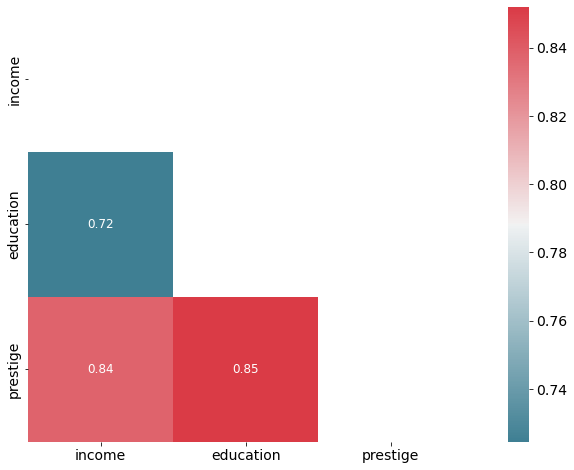

In [33]:
# Inspect correlation
# Calculate correlation using the default method ( "pearson")
corr = df.corr()
# optimize aesthetics: generate mask for removing duplicate / unnecessary info
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap as indicator for correlations:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,  square=True, annot_kws={"size": 12});


### Variance inflation factor (VIF)

Instead of inspecting the correlation matrix, a better way to assess multicollinearity is to compute the variance inflation factor (VIF). 

The smallest possible value for VIF is 1, which indicates the complete absence of collinearity. Typically in practice there is a small amount of collinearity among the predictors. We ignore the intercept in this test.

As a rule of thumb, a VIF value that exceeds 5 indicates a problematic amount of collinearity and the parameter estimates will have large standard errors because of this. 

In [41]:
y, X = dmatrices('prestige ~ income + education', df, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns

vif.round(2)

,VIF Factor,Feature
0,4.59,Intercept
1,2.10,income
2,2.10,education


We don't have a problematic amount of collinearity in our data.